Num EBs:		 3485
Num EBs are SBs:	 515


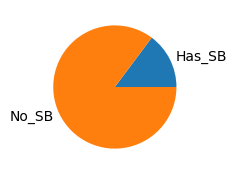

In [2]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


df = pd.read_csv("pht_vsx_eb_with_sb.csv", dtype={
    "GAIA_Source": "uint64",  # ensure it's large enough
    "NSS_Flags": "Int64",  # make it nullable int
    })
df["Period_Ratio_EB_SB"] = df["VSX_Period"] / df["NSS_Per"]
df["Period_Delta_EB_SB"] = np.abs(df["VSX_Period"] - df["NSS_Per"])

df["Has_SB"] = pd.notna(df["NSS_Per"])

df_m1 = df[df["Has_SB"]]  # those with SBs


print("Num EBs:\t\t", len(df))
print("Num EBs are SBs:\t", len(df_m1))

ax = plt.figure(figsize=(2, 2)).gca()
ax.pie(
    [ len(df_m1), len(df) - len(df_m1), ],
    labels=["Has_SB", "No_SB"],
    );

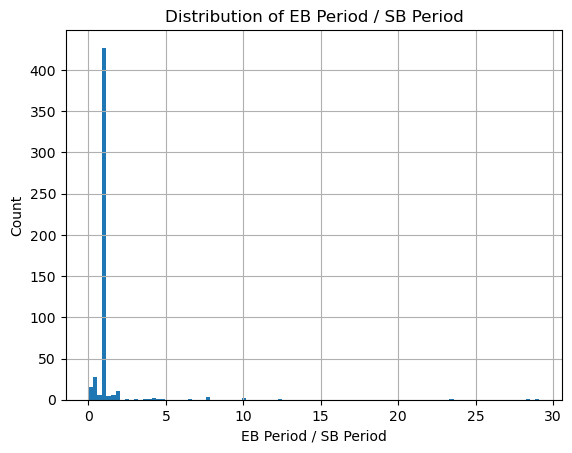

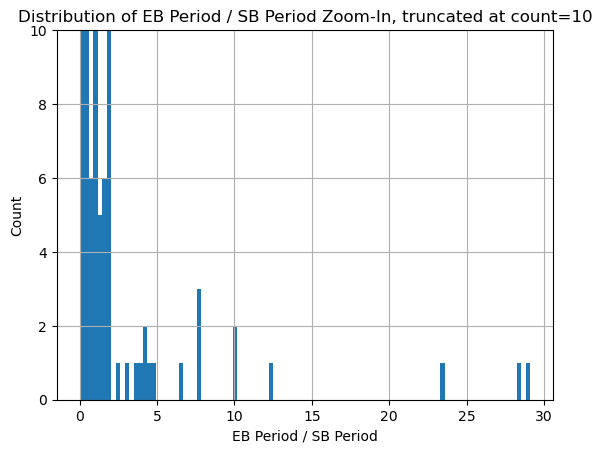

In [3]:
ax = df_m1["Period_Ratio_EB_SB"].hist(bins=100)
ax.set_title("Distribution of EB Period / SB Period");
ax.set_xlabel("EB Period / SB Period");
ax.set_ylabel("Count");
plt.show();

ax = df_m1["Period_Ratio_EB_SB"].hist(bins=100)
ax.set_ylim(0, 10);
ax.set_title("Distribution of EB Period / SB Period Zoom-In, truncated at count=10");
ax.set_xlabel("EB Period / SB Period");
ax.set_ylabel("Count");

## List of targets with significant difference in EB period and SB period

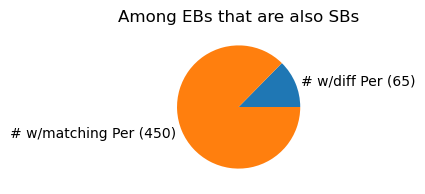

In [4]:
# now exclude those that closely match EB period (ratio ~1, ~0.5 ~2)

def not_in_range(df, column, range_min, range_max):
    return df[~((range_min < df[column]) & (df[column] < range_max))]


df_m2 = df_m1
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 0.99, 1.01)
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 0.495, 0.505)
df_m2 = not_in_range(df_m2, "Period_Ratio_EB_SB", 1.98, 2.02)
df_m2 = not_in_range(df_m2, "Period_Delta_EB_SB", 0.0, 0.1)  # also exclude those the absolute difference is small

df_m2.sort_values(by="Period_Ratio_EB_SB", inplace=True)

ax = plt.figure(figsize=(2, 2)).gca()
ax.pie(
    [ len(df_m2), len(df_m1) - len(df_m2), ],
    labels=[f"# w/diff Per ({len(df_m2)})", f"# w/matching Per ({len(df_m1) - len(df_m2)})"],
    );
ax.set_title("Among EBs that are also SBs");


## Multi-star system candidates

- targets with signfiicant difference in EB and SB periods
- `has_etv`: status of ETV analysis (more later)

In [34]:
# join `df_m2`, multi-star system candidates, with etv analysis done in `etv_summary.csv`
df_etv = pd.read_csv("etv/etv_summary.csv", 
                     dtype={"num_sectors": "Int32",  # make num_secors nullable int, to handle  missing value cases
                            "tic": "Int64", 
                           }, 
                     converters={"has_etv": str}, # ensure blank value stays blank
                    )
df_etv['etv_done'] = True  # helper column to indicate if a row has ETV analysis after the join below
df_etv = pd.merge(df_etv, df_m2, left_on="tic", right_on="tic_id", how="outer")
df_etv.rename(columns={
    "period": "ETV_Period", 
    "num_sectors_y": "num_subjects",  #  the num_sectors from df_m2 is actually num. of PHT subjects matched
    "num_sectors_x": "num_sectors"
}, inplace=True)


def display_dashboard(df_etv, display_columns):    
    with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
        # make all float columns (except periods) to display in 2 decimals
        columns_to_show_2_decimals = [c for c in df_etv.columns  if 'float' in str(df_etv[c].dtype) and c not in ['ETV_Period', 'VSX_Period', 'NSS_Per', 'period']]
        format_specs = dict(zip(columns_to_show_2_decimals, ["{:.2f}"] * len(columns_to_show_2_decimals)))
        # tic column: from ETV analysis, tic_id : applicable for all candidates
        format_specs["tic"] = lambda tic: f'<a target="_etv_report" href="etv/ETV_extraction_coshgauss_{tic}.ipynb">{tic}</a>'
        format_specs["tic_id"] = lambda tic: f'<a target="_exofop" href="https://exofop.ipac.caltech.edu/tess/target.php?id={tic}">{tic}</a>'  
        format_specs["TESS"] = lambda tic: f'<a target="_exofop" href="https://exofop.ipac.caltech.edu/tess/target.php?id={tic}">{tic}</a>'  
        format_specs["best_subject_id"] = lambda subj: f'<a target="_pht_subject" href="https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/subjects/{subj}">{subj}</a>'
        format_specs["VSX_OID"] = lambda oid: f'<a target="_vsx" href="https://www.aavso.org/vsx/index.php?view=detail.top&oid={oid}">{oid}</a>'
        format_specs["GAIA"] = lambda gid: f'<a target="_gaia_main" href="https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source={gid}&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET">Gaia</a>'
        format_specs["NSS"] = lambda gid: f'<a target="_gaia_nss" href="https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=I%2F357&%2F%2Ftables=I%2F357%2Ftboasb1c&%2F%2Ftables=I%2F357%2Ftboeb&%2F%2Ftables=I%2F357%2Ftboes&%2F%2Ftables=I%2F357%2Ftbooc&%2F%2Ftables=I%2F357%2Ftbooac&%2F%2Ftables=I%2F357%2Ftbooavc&%2F%2Ftables=I%2F357%2Ftbootsc&%2F%2Ftables=I%2F357%2Ftbootsvc&%2F%2Ftables=I%2F357%2Ftbosb1&%2F%2Ftables=I%2F357%2Ftbosb1c&%2F%2Ftables=I%2F357%2Ftbosb2&%2F%2Ftables=I%2F357%2Ftbosb2c&%2F%2Ftables=I%2F357%2Facc7&%2F%2Ftables=I%2F357%2Facc9&%2F%2Ftables=I%2F357%2Flinspec1&%2F%2Ftables=I%2F357%2Flinspec2&%2F%2Ftables=I%2F357%2Fvimfl&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F357%2Ftboasb1c%2CI%2F357%2Ftboeb%2CI%2F357%2Ftboes%2CI%2F357%2Ftbooc%2CI%2F357%2Ftbooac%2CI%2F357%2Ftbooavc%2CI%2F357%2Ftbootsc%2CI%2F357%2Ftbootsvc%2CI%2F357%2Ftbosb1%2CI%2F357%2Ftbosb1c%2CI%2F357%2Ftbosb2%2CI%2F357%2Ftbosb2c%2CI%2F357%2Facc7%2CI%2F357%2Facc9%2CI%2F357%2Flinspec1%2CI%2F357%2Flinspec2%2CI%2F357%2Fvimfl&-nav=cat%3AI%2F357%26tab%3A%7BI%2F357%2Ftboasb1c%7D%26tab%3A%7BI%2F357%2Ftboeb%7D%26tab%3A%7BI%2F357%2Ftboes%7D%26tab%3A%7BI%2F357%2Ftbooc%7D%26tab%3A%7BI%2F357%2Ftbooac%7D%26tab%3A%7BI%2F357%2Ftbooavc%7D%26tab%3A%7BI%2F357%2Ftbootsc%7D%26tab%3A%7BI%2F357%2Ftbootsvc%7D%26tab%3A%7BI%2F357%2Ftbosb1%7D%26tab%3A%7BI%2F357%2Ftbosb1c%7D%26tab%3A%7BI%2F357%2Ftbosb2%7D%26tab%3A%7BI%2F357%2Ftbosb2c%7D%26tab%3A%7BI%2F357%2Facc7%7D%26tab%3A%7BI%2F357%2Facc9%7D%26tab%3A%7BI%2F357%2Flinspec1%7D%26tab%3A%7BI%2F357%2Flinspec2%7D%26tab%3A%7BI%2F357%2Fvimfl%7D%26key%3Asource%3DI%2F357%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F357%2Ftboasb1c+I%2F357%2Ftboeb+I%2F357%2Ftboes+I%2F357%2Ftbooc+I%2F357%2Ftbooac+I%2F357%2Ftbooavc+I%2F357%2Ftbootsc+I%2F357%2Ftbootsvc+I%2F357%2Ftbosb1+I%2F357%2Ftbosb1c+I%2F357%2Ftbosb2+I%2F357%2Ftbosb2c+I%2F357%2Facc7+I%2F357%2Facc9+I%2F357%2Flinspec1+I%2F357%2Flinspec2+I%2F357%2Fvimfl&-out.orig=standard&-out=Source&Source={gid}&-out=NSSmodel&-out=RA_ICRS&-out=DE_ICRS&-out=Plx&-out=pmRA&-out=pmDE&-out=ATI&-out=BTI&-out=FTI&-out=GTI&-out=CTI&-out=HTI&-out=Per&-out=Tperi&-out=ecc&-out=Vcm&-out=Flags&-out=_RA.icrs&-out=_DE.icrs&-out=ffactp&-out=ffacts&-out=inc&-out=Tratio&-out=Teclp&-out=Tecls&-out=Durp&-out=Durs&-out=K1&-out=MassRatio&-out=K2&-out=dpmRA&-out=dpmDE&-out=ddpmRA&-out=ddpmDE&-out=Velmean&-out=dVel%2Fdt&-out=dVel%2Fdt2&-out=RAVIM&-out=DEVIM&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET">NSS</a>'

        # add placeholder columns for links to Gaia, ExoFOP, etc.
        df_display = df_etv.copy()
        if "GAIA_Source" in df_display.columns:
            df_display['GAIA'] = df_display["GAIA_Source"]
            df_display['NSS'] = df_display["GAIA_Source"]
        if "TESS" not in df_display.columns and "tic" in df_display.columns:
            df_display["TESS"] = df_display["tic"]

        return display(df_display[display_columns].style.format(format_specs))


In [35]:
print("Num. of targets with significant difference in EB / SB periods:", len(df_m2))

display_columns = [
    "tic_id",
    "has_etv",  # etv analysis status
   "best_subject_id",
   "num_subjects",  # a proxy only, as it's the num. of sectors with PHT eb tags, there could have more data in sectors not tagged.
   "VSX_OID", "VSX_Type",
   "VSX_Period", "NSS_Per", "Period_Ratio_EB_SB",
   "GAIA_sepsi", "GAIA_RUWE", "GAIA_e_RV",
   "NSS_Vcm", "NSS_Flags",
    "GAIA", "NSS",  # links to Gaia main / NSS
] 
display_dashboard(
    (df_etv
    ).sort_values(by="Period_Ratio_EB_SB").reset_index(), display_columns)

display(HTML(f"""The list in <a href="multi_star_candidates_by_eb_sb_period_diff.csv" target="_blank">csv file</a>"""));

Num. of targets with significant difference in EB / SB periods: 65


,tic_id,has_etv,best_subject_id,num_subjects,VSX_OID,VSX_Type,VSX_Period,NSS_Per,Period_Ratio_EB_SB,GAIA_sepsi,GAIA_RUWE,GAIA_e_RV,NSS_Vcm,NSS_Flags,GAIA,NSS
0,36883123,Y?,30149148,3,14160,EW,0.335270,1085.541825,0.00,2593.70,11.08,1.06,17.35,0,"<a target=""_gaia_main"" href=""https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=5173394868034819968&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET"">Gaia","<a target=""_gaia_nss"" href=""https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=I%2F357&%2F%2Ftables=I%2F357%2Ftboasb1c&%2F%2Ftables=I%2F357%2Ftboeb&%2F%2Ftables=I%2F357%2Ftboes&%2F%2Ftables=I%2F357%2Ftbooc&%2F%2Ftables=I%2F357%2Ftbooac&%2F%2Ftables=I%2F357%2Ftbooavc&%2F%2Ftables=I%2F357%2Ftbootsc&%2F%2Ftables=I%2F357%2Ftbootsvc&%2F%2Ftables=I%2F357%2Ftbosb1&%2F%2Ftables=I%2F357%2Ftbosb1c&%2F%2Ftables=I%2F357%2Ftbosb2&%2F%2Ftables=I%2F357%2Ftbosb2c&%2F%2Ftables=I%2F357%2Facc7&%2F%2Ftables=I%2F357%2Facc9&%2F%2Ftables=I%2F357%2Flinspec1&%2F%2Ftables=I%2F357%2Flinspec2&%2F%2Ftables=I%2F357%2Fvimfl&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F357%2Ftboasb1c%2CI%2F357%2Ftboeb%2CI%2F357%2Ftboes%2CI%2F357%2Ftbooc%2CI%2F357%2Ftbooac%2CI%2F357%2Ftbooavc%2CI%2F357%2Ftbootsc%2CI%2F357%2Ftbootsvc%2CI%2F357%2Ftbosb1%2CI%2F357%2Ftbosb1c%2CI%2F357%2Ftbosb2%2CI%2F357%2Ftbosb2c%2CI%2F357%2Facc7%2CI%2F357%2Facc9%2CI%2F357%2Flinspec1%2CI%2F357%2Flinspec2%2CI%2F357%2Fvimfl&-nav=cat%3AI%2F357%26tab%3A%7BI%2F357%2Ftboasb1c%7D%26tab%3A%7BI%2F357%2Ftboeb%7D%26tab%3A%7BI%2F357%2Ftboes%7D%26tab%3A%7BI%2F357%2Ftbooc%7D%26tab%3A%7BI%2F357%2Ftbooac%7D%26tab%3A%7BI%2F357%2Ftbooavc%7D%26tab%3A%7BI%2F357%2Ftbootsc%7D%26tab%3A%7BI%2F357%2Ftbootsvc%7D%26tab%3A%7BI%2F357%2Ftbosb1%7D%26tab%3A%7BI%2F357%2Ftbosb1c%7D%26tab%3A%7BI%2F357%2Ftbosb2%7D%26tab%3A%7BI%2F357%2Ftbosb2c%7D%26tab%3A%7BI%2F357%2Facc7%7D%26tab%3A%7BI%2F357%2Facc9%7D%26tab%3A%7BI%2F357%2Flinspec1%7D%26tab%3A%7BI%2F357%2Flinspec2%7D%26tab%3A%7BI%2F357%2Fvimfl%7D%26key%3Asource%3DI%2F357%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F357%2Ftboasb1c+I%2F357%2Ftboeb+I%2F357%2Ftboes+I%2F357%2Ftbooc+I%2F357%2Ftbooac+I%2F357%2Ftbooavc+I%2F357%2Ftbootsc+I%2F357%2Ftbootsvc+I%2F357%2Ftbosb1+I%2F357%2Ftbosb1c+I%2F357%2Ftbosb2+I%2F357%2Ftbosb2c+I%2F357%2Facc7+I%2F357%2Facc9+I%2F357%2Flinspec1+I%2F357%2Flinspec2+I%2F357%2Fvimfl&-out.orig=standard&-out=Source&Source=5173394868034819968&-out=NSSmodel&-out=RA_ICRS&-out=DE_ICRS&-out=Plx&-out=pmRA&-out=pmDE&-out=ATI&-out=BTI&-out=FTI&-out=GTI&-out=CTI&-out=HTI&-out=Pe

In [36]:
# save the results as csv
# df_m2.to_csv("multi_star_candidates_by_eb_sb_period_diff.csv", index=False)

## Eclipse Timing Variation (ETV) Analysis


In [37]:
display_columns = ["tic", "has_etv", "comments", 
                   # "VSX_Type",
                   "ETV_Period",  "VSX_Period", "NSS_Per", "Period_Ratio_EB_SB", 
                   "depth_pct_p", "depth_pct_s",
                   "GAIA_sepsi", "GAIA_RUWE", "GAIA_e_RV",
                   "num_sectors", "time_span",  # time span of the data in ETV analysis
                   "TESS", "VSX_OID", "GAIA",'NSS',  # links to ExoFOP, VSX, Gaia DR3
                  ]
display_dashboard(
    df_etv[~pd.isna(df_etv["etv_done"])], 
     display_columns)

,tic,has_etv,comments,ETV_Period,VSX_Period,NSS_Per,Period_Ratio_EB_SB,depth_pct_p,depth_pct_s,GAIA_sepsi,GAIA_RUWE,GAIA_e_RV,num_sectors,time_span,TESS,VSX_OID,GAIA,NSS
0,272650576,N?,"No changes in O-C in primary; scatter in O-C is secondary, unsure if there is any pattern. Data possibly too sparse. Results from using period from TCE1 and MCMC are similar.",16.256853,16.257000,4.649853,3.50,23.81,13.44,23.56,1.08,nan,16,1169.78,272650576,400339,"<a target=""_gaia_main"" href=""https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6578bb1b54eda&-to=-4b&-from=-4&-this=-4&%2F%2Fsource=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3DI%2F355%2Fgaiadr3%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=1695777986109779840&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=IPDfmp&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=0&-meta=0&-usenav=1&-bmark=GET"">Gaia","<a target=""_gaia_nss"" href=""https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65a1a2351812e4&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=I%2F357&%2F%2Ftables=I%2F357%2Ftboasb1c&%2F%2Ftables=I%2F357%2Ftboeb&%2F%2Ftables=I%2F357%2Ftboes&%2F%2Ftables=I%2F357%2Ftbooc&%2F%2Ftables=I%2F357%2Ftbooac&%2F%2Ftables=I%2F357%2Ftbooavc&%2F%2Ftables=I%2F357%2Ftbootsc&%2F%2Ftables=I%2F357%2Ftbootsvc&%2F%2Ftables=I%2F357%2Ftbosb1&%2F%2Ftables=I%2F357%2Ftbosb1c&%2F%2Ftables=I%2F357%2Ftbosb2&%2F%2Ftables=I%2F357%2Ftbosb2c&%2F%2Ftables=I%2F357%2Facc7&%2F%2Ftables=I%2F357%2Facc9&%2F%2Ftables=I%2F357%2Flinspec1&%2F%2Ftables=I%2F357%2Flinspec2&%2F%2Ftables=I%2F357%2Fvimfl&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-out.src=I%2F357%2Ftboasb1c%2CI%2F357%2Ftboeb%2CI%2F357%2Ftboes%2CI%2F357%2Ftbooc%2CI%2F357%2Ftbooac%2CI%2F357%2Ftbooavc%2CI%2F357%2Ftbootsc%2CI%2F357%2Ftbootsvc%2CI%2F357%2Ftbosb1%2CI%2F357%2Ftbosb1c%2CI%2F357%2Ftbosb2%2CI%2F357%2Ftbosb2c%2CI%2F357%2Facc7%2CI%2F357%2Facc9%2CI%2F357%2Flinspec1%2CI%2F357%2Flinspec2%2CI%2F357%2Fvimfl&-nav=cat%3AI%2F357%26tab%3A%7BI%2F357%2Ftboasb1c%7D%26tab%3A%7BI%2F357%2Ftboeb%7D%26tab%3A%7BI%2F357%2Ftboes%7D%26tab%3A%7BI%2F357%2Ftbooc%7D%26tab%3A%7BI%2F357%2Ftbooac%7D%26tab%3A%7BI%2F357%2Ftbooavc%7D%26tab%3A%7BI%2F357%2Ftbootsc%7D%26tab%3A%7BI%2F357%2Ftbootsvc%7D%26tab%3A%7BI%2F357%2Ftbosb1%7D%26tab%3A%7BI%2F357%2Ftbosb1c%7D%26tab%3A%7BI%2F357%2Ftbosb2%7D%26tab%3A%7BI%2F357%2Ftbosb2c%7D%26tab%3A%7BI%2F357%2Facc7%7D%26tab%3A%7BI%2F357%2Facc9%7D%26tab%3A%7BI%2F357%2Flinspec1%7D%26tab%3A%7BI%2F357%2Flinspec2%7D%26tab%3A%7BI%2F357%2Fvimfl%7D%26key%3Asource%3DI%2F357%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=I%2F357%2Ftboasb1c+I%2F357%2Ftboeb+I%2F357%2Ftboes+I%2F357%2Ftbooc+I%2F357%2Ftbooac+I%2F357%2Ftbooavc+I%2F357%2Ftbootsc+I%2F357%2Ftbootsvc+I%2F357%2Ftbosb1+I%2F357%2Ftbosb1c+I%2F357%2Ftbosb2+I%2F357%2Ftbosb2c+I%2F357%2Facc7+I%2F357%2Facc9+I%2F357%2Flinspec1+I%2F357%2Flinspec

## ETV Analysis for miscellaneous targets 

For targets **unrelated to** the above candidates (from apparent difference between EB Period and SB Period)

In [38]:
df_misc_etv = pd.read_csv("etv/misc_etv_summary.csv", 
                     dtype={"num_sectors": "Int32",  # make num_secors nullable int, to handle  missing value cases
                            "tic": "Int64", 
                           }, 
                     converters={"has_etv": str}, # ensure blank value stays blank
                    )

display_columns = ["tic", "has_etv", "comments", 
                   "period",
                   "depth_pct_p", "depth_pct_s",
                   "num_sectors", "time_span",  # time span of the data in ETV analysis
                   "TESS",  # links to ExoFOP
                  ]
display_dashboard(
    df_misc_etv,
     display_columns)

,tic,has_etv,comments,period,depth_pct_p,depth_pct_s,num_sectors,time_span,TESS
0,298264838,?,scatter in O-C with no obvious pattern. Unsure if the cosh model can handle the assyemtirc eclipses. Unsure if the period is good enough.,0.291278,7.28,6.19,8,980.89,298264838
1,52357,Y?,Mightbe ETV for both primary and secondary in 3 separate sectors. Ot it might be due to imprecise period. 2 slightly different period (from TCE1 and MCMC) shows comparable result though.,0.547540,1.05,0.47,3,1499.85,52357
